# Bollinger bands - Traling SL

## Import Library

In [1]:
import sys
sys.path.append('../../')

In [2]:

from config.constants import *
from backtesting import Backtest
from util.plot_equity import plot_equity_trades
from util.load_data import load_data
from Bolinger_bands import Bolinger_bands
from util.Save_result_return import save_to_csv
import matplotlib.pyplot as plt
from config.interations import iterations
import pandas as pd
import seaborn as sns
from tqdm import tqdm



## Get Data

In [3]:
XAUUSD = load_data()

In [4]:
XAUUSD['D1'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5043 entries, 2007-01-01 to 2023-03-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5043 non-null   float64
 1   High    5043 non-null   float64
 2   Low     5043 non-null   float64
 3   Close   5043 non-null   float64
 4   Volume  5043 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 236.4 KB


## Define Strategy

In [5]:
strategy = Bolinger_bands

In [6]:
account_size = 20000

In [7]:
iterations = iterations

In [8]:
iterations

[{'in_sample': [datetime.datetime(2007, 1, 1, 0, 0),
   datetime.datetime(2010, 12, 31, 0, 0)],
  'out_of_sample': [datetime.datetime(2011, 1, 1, 0, 0),
   datetime.datetime(2012, 12, 31, 0, 0)]},
 {'in_sample': [datetime.datetime(2008, 1, 1, 0, 0),
   datetime.datetime(2011, 12, 31, 0, 0)],
  'out_of_sample': [datetime.datetime(2012, 1, 1, 0, 0),
   datetime.datetime(2013, 12, 31, 0, 0)]},
 {'in_sample': [datetime.datetime(2009, 1, 1, 0, 0),
   datetime.datetime(2012, 12, 31, 0, 0)],
  'out_of_sample': [datetime.datetime(2013, 1, 1, 0, 0),
   datetime.datetime(2014, 12, 31, 0, 0)]},
 {'in_sample': [datetime.datetime(2010, 1, 1, 0, 0),
   datetime.datetime(2013, 12, 31, 0, 0)],
  'out_of_sample': [datetime.datetime(2014, 1, 1, 0, 0),
   datetime.datetime(2015, 12, 31, 0, 0)]},
 {'in_sample': [datetime.datetime(2011, 1, 1, 0, 0),
   datetime.datetime(2014, 12, 31, 0, 0)],
  'out_of_sample': [datetime.datetime(2015, 1, 1, 0, 0),
   datetime.datetime(2016, 12, 31, 0, 0)]},
 {'in_sample': 

# Walk-Forward Optimization

In [9]:
folder_strategy = 'Bolinger_bands'

## TF D1

In [10]:
data = XAUUSD['D1']
TF = 'D1'

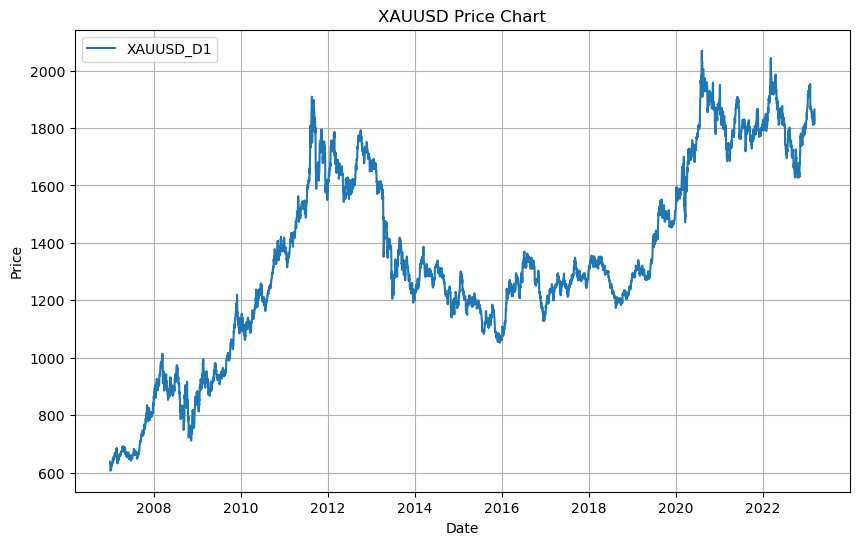

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='XAUUSD_D1')
plt.title('XAUUSD Price Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### Define the Parameters of a Walk-Forward Optimization

In [12]:
def Walk_Forward_Optimization(data, strategy, iterations):

    results_oos = []
    results_is = []
    report = []
    # 1: We iterate over the list of dictionaries
    for iter in tqdm(iterations):

        # 2: We filter the data to only include the relevant dates.
        df_is = data[(data.index >= iter['in_sample'][0])
                     & (data.index <= iter['in_sample'][1])]
        df_oos = data[(data.index >= iter['out_of_sample'][0]) & (
            data.index <= iter['out_of_sample'][1])]

        bt_is = Backtest(df_is, strategy, cash=10_000,
                         commission=0, exclusive_orders=True)

        # 3: Calcualte the optimal parameters using the in-sample data.
        stats_is, heatmap = bt_is.optimize(
            band_High = range(40, 60, 2),
            band_Low = range(1, 6, 1),
           

            maximize='Sharpe Ratio',
            method='grid',
            max_tries=50,
            random_state=0,
            return_heatmap=True)
        results_is.append(stats_is)
        strategy.band_High = stats_is._strategy.band_High
        strategy.band_Low = stats_is._strategy.band_Low

        # 4: Run the backtest for the out-of-sample data using the optimal parameters.
        bt_oos = Backtest(df_oos, strategy, cash=10_000,
                          commission=0, exclusive_orders=True)
        stats_oos = bt_oos.run()
        results_oos.append(stats_oos)

        # 5: Append relevant metrics to a list of results
        report.append({
            'start_date': stats_oos['Start'],
            'end_date': stats_oos['End'],
            'return': stats_oos['Return [%]'],
            'max_drawdown': stats_oos['Max. Drawdown [%]'],
            'return_ann': stats_oos['Return (Ann.) [%]'],
            'volatility__ann': stats_oos['Volatility (Ann.) [%]'],
            'sharpe_is': stats_is['Sharpe Ratio'],
            'sharpe_ratio': stats_oos['Sharpe Ratio'],
            'Sortino Ratio': stats_oos['Sortino Ratio'],
            'is_heatmap': heatmap,
        })

    return results_is, results_oos, report

In [13]:
results_is_D1, results_oos_D1, report_D1 = Walk_Forward_Optimization(data, strategy,iterations)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  9%|▉         | 1/11 [01:20<13:21, 80.18s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [02:51<12:58, 86.45s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [04:25<12:02, 90.25s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [06:06<11:01, 94.46s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [07:35<09:14, 92.47s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 55%|█████▍    | 6/11 [08:53<07:17, 87.53s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 64%|██████▎   | 7/11 [10:26<05:57, 89.38s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 73%|███████▎  | 8/11 [12:02<04:34, 91.45s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 82%|████████▏ | 9/11 [13:39<03:05, 92.99s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 91%|█████████ | 10/11 [15:29<01:38, 98.52s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 11/11 [17:16<00:00, 94.21s/it] 


In [14]:
pd.DataFrame(report_D1)

,start_date,end_date,return,max_drawdown,return_ann,volatility__ann,sharpe_is,sharpe_ratio,Sortino Ratio,is_heatmap
0,2011-01-02,2012-12-31,-2.386644,-3.240013,-0.972333,1.566125,0.486281,0.000000,0.000000,band_High band_Low 40 1 0.4...
1,2012-01-02,2013-12-31,2.389672,-1.917642,0.959817,1.473800,0.300983,0.651253,1.092227,band_High band_Low 40 1 0.2...
2,2013-01-01,2014-12-31,-1.032866,-2.131952,-0.419753,1.106157,0.358495,0.000000,0.000000,band_High band_Low 40 1 0.2...
3,2014-01-01,2015-12-31,1.370779,-1.511795,0.553116,1.085305,0.526087,0.509641,0.747026,band_High band_Low 40 1 0.4...
4,2015-01-01,2016-12-30,2.601948,-0.935716,1.047812,1.185175,0.000000,0.884099,1.564001,band_High band_Low 40 1 0.0...
5,2016-01-03,2017-12-29,-0.743698,-1.984116,-0.303436,0.672111,0.273013,0.000000,0.000000,band_High band_Low 40 1 0.2...
6,2017-01-02,2018-12-31,-0.403124,-1.208650,-0.163783,0.691480,0.391683,0.000000,0.000000,band_High band_Low 40 1 0.3...
7,2018-01-01,2019-12-31,0.460228,-1.264570,0.185607,0.992011,0.473757,0.187102,0.289980,band_High band_Low 40 1 0.4...
8,2019-01-01,2020-12-31,2.408968,-2.152397,0.965955,1.768763,0.319345,0.546119,0.778934,band_High band_Low 40 1 0.3...
9,2020-01-01,2021-12-31,-3.831000,-3.831000,-1.570164,1.406033,0.141852,0.000000,0.000000,band_High band_Low 40 1 0.1...


### Plot Heatmap

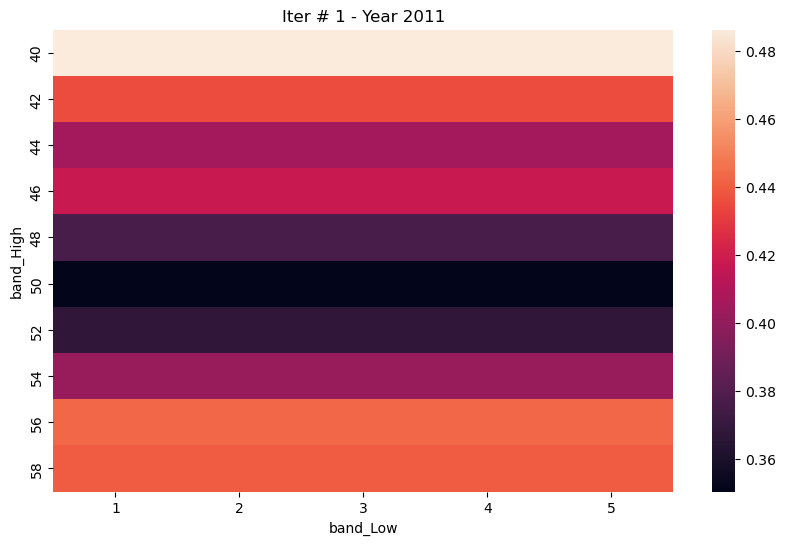

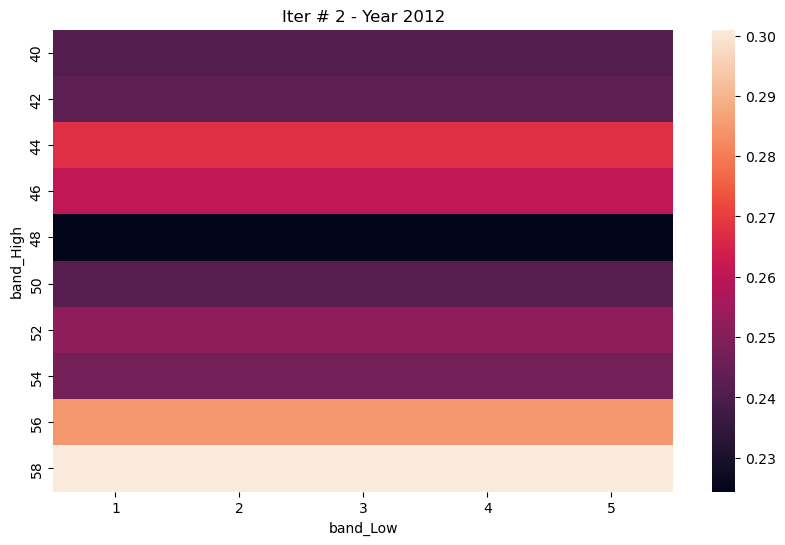

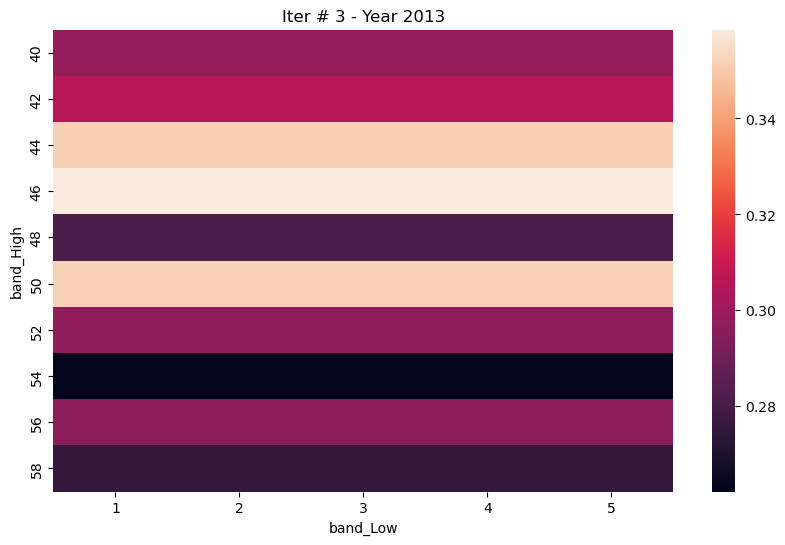

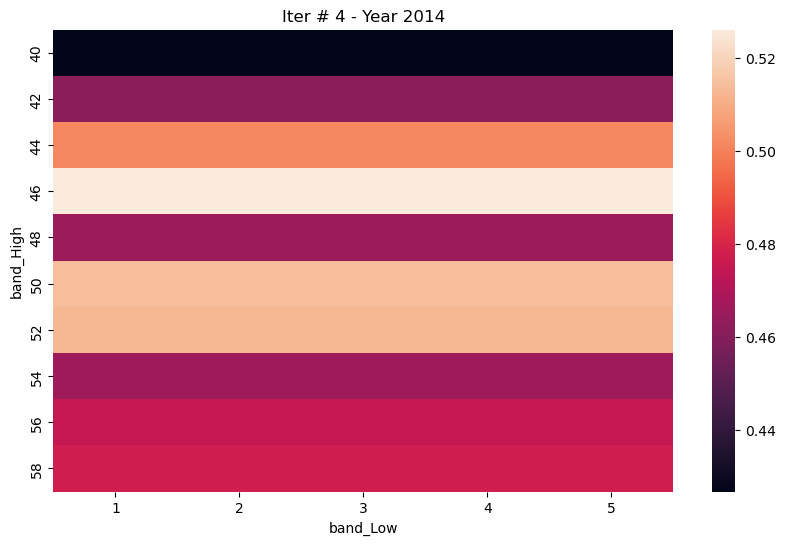

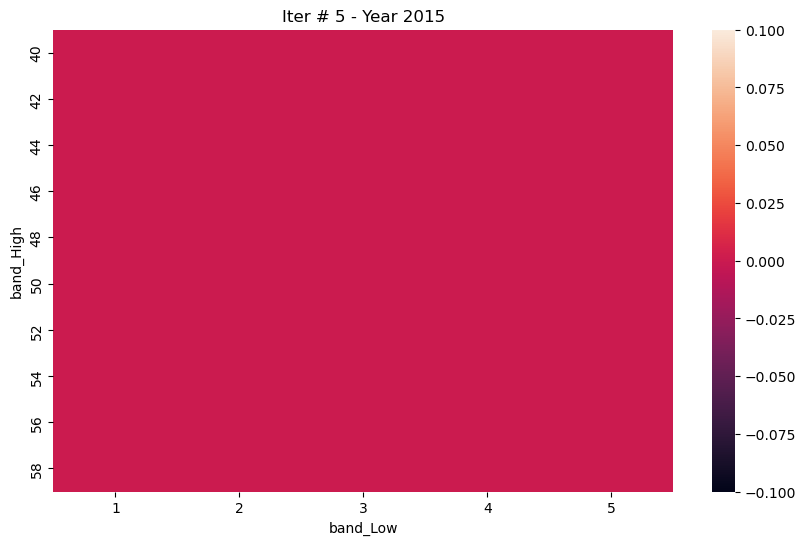

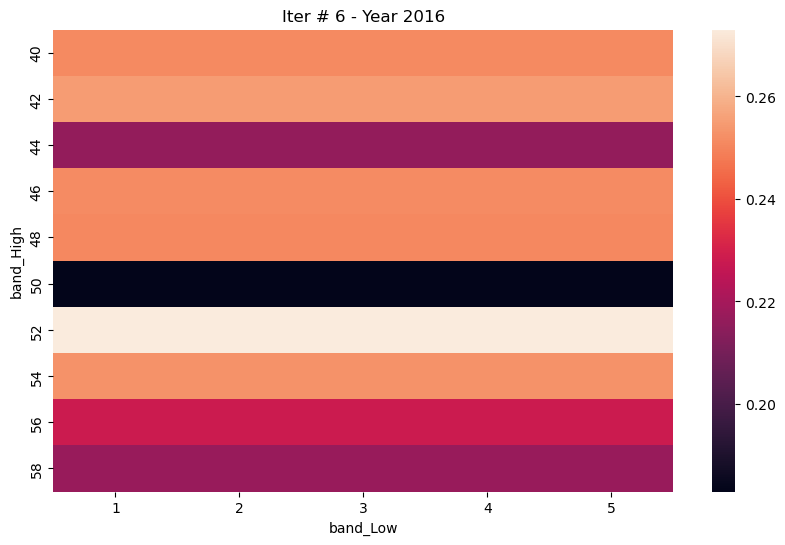

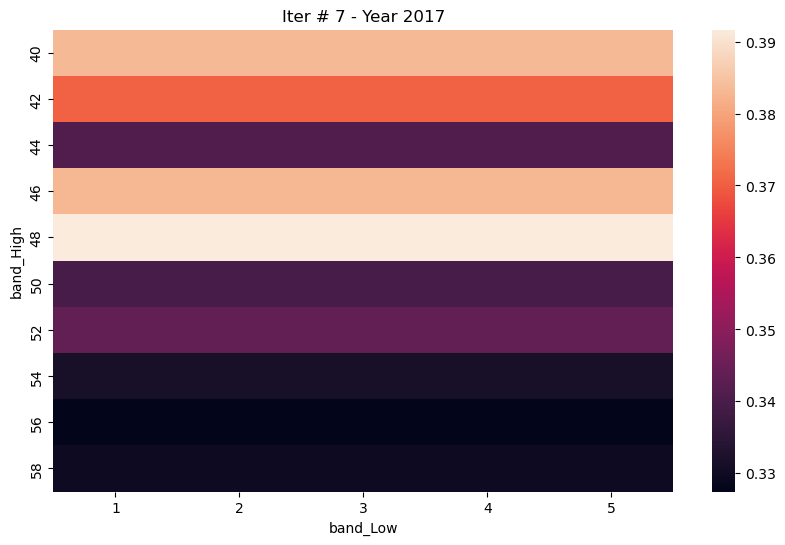

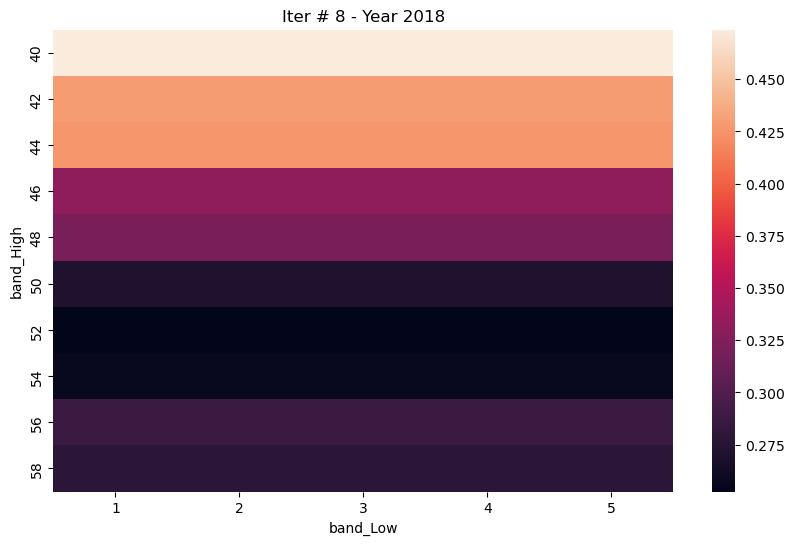

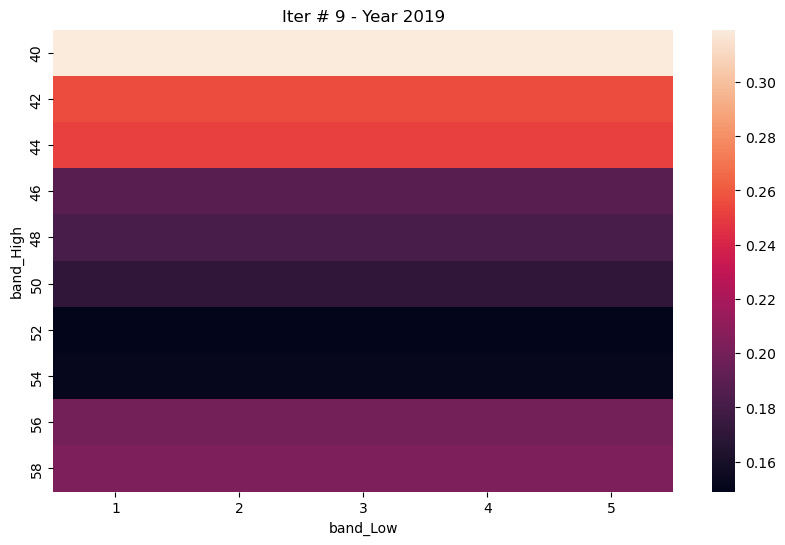

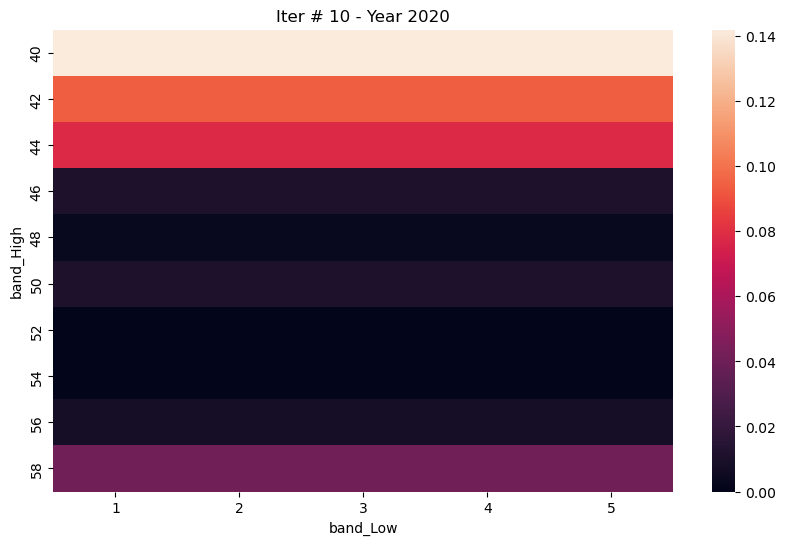

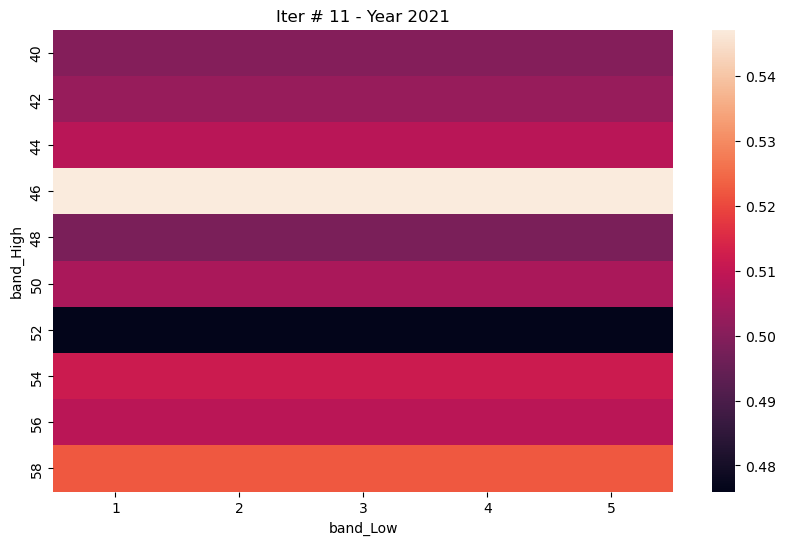

In [15]:
import matplotlib.pyplot as plt

rows = len(report_D1)
for idx, res in enumerate(report_D1):
    plt.figure(figsize=(10, 6))
    plt.plot(idx+1)
    plt.title(f"Iter # {idx+1} - Year {res['start_date'].year}")
    sns.heatmap(res['is_heatmap'].unstack())
    plt.show()

### Save output

In [17]:
for i in range(len(iterations)) :
    save_to_csv(
        results_is_D1[i], f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_is_{i+1}_{TF}.csv')
    
    save_to_csv(
        results_oos_D1[i], f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_oos_{i+1}_{TF}.csv')

In [18]:
results_is_All_D1 = pd.DataFrame()  
for df in results_is_D1:
    results_is_All_D1 = pd.concat(
        [results_is_All_D1, df['_equity_curve']], axis=0, ignore_index=False)
pd.DataFrame(results_is_All_D1)

,Equity,DrawdownPct,DrawdownDuration
Time,,,
2007-01-01,10000.000000,0.000000,NaT
2007-01-02,10000.000000,0.000000,NaT
2007-01-03,10000.000000,0.000000,NaT
2007-01-04,10000.000000,0.000000,NaT
2007-01-05,10000.000000,0.000000,NaT
...,...,...,...
2020-12-27,10381.502675,0.017915,NaT
2020-12-28,10370.009675,0.019002,NaT
2020-12-29,10372.062675,0.018808,NaT


In [19]:
results_oos_All_D1 = pd.DataFrame()
for df in results_oos_D1:
    results_oos_All_D1 = pd.concat(
        [results_oos_All_D1, df['_equity_curve']], axis=0, ignore_index=False)
pd.DataFrame(results_oos_All_D1)

,Equity,DrawdownPct,DrawdownDuration
Time,,,
2011-01-02,10000.000000,0.000000,NaT
2011-01-03,10000.000000,0.000000,NaT
2011-01-04,10000.000000,0.000000,NaT
2011-01-05,10000.000000,0.000000,NaT
2011-01-06,10000.000000,0.000000,NaT
...,...,...,...
2022-12-26,9814.814475,0.018519,NaT
2022-12-27,9814.814475,0.018519,NaT
2022-12-28,9814.814475,0.018519,NaT


In [20]:
results_is_All_D1.to_csv(
    f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_is_All_{TF}.csv', index=True)

In [21]:
results_oos_All_D1.to_csv(
    f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_oos_All_{TF}.csv', index=True)

## TF H4

In [22]:
data = XAUUSD['H4']
TF = 'H4'

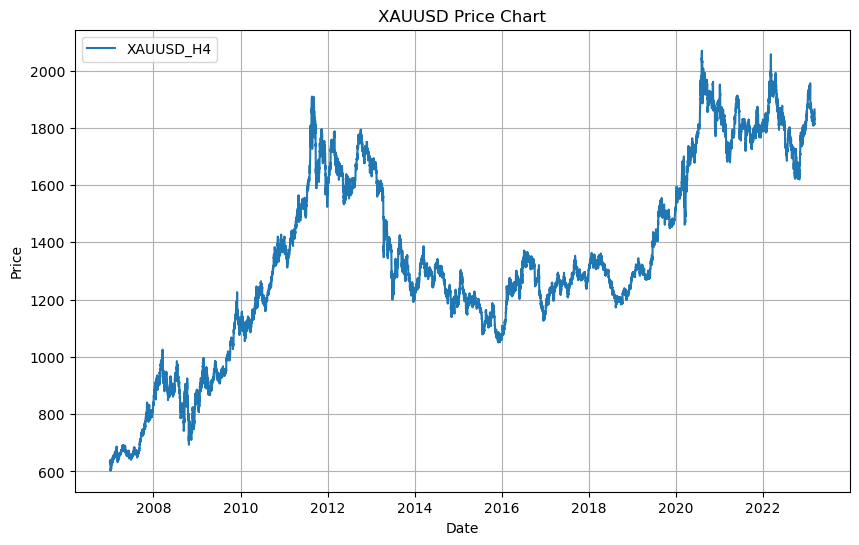

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label=f'XAUUSD_{TF}')
plt.title('XAUUSD Price Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### Define the Parameters of a Walk-Forward Optimization

In [24]:
def Walk_Forward_Optimization(data, strategy, iterations):

    results_oos = []
    results_is = []
    report = []
    # 1: We iterate over the list of dictionaries
    for iter in tqdm(iterations):

        # 2: We filter the data to only include the relevant dates.
        df_is = data[(data.index >= iter['in_sample'][0])
                     & (data.index <= iter['in_sample'][1])]
        df_oos = data[(data.index >= iter['out_of_sample'][0]) & (
            data.index <= iter['out_of_sample'][1])]

        bt_is = Backtest(df_is, strategy, cash=10_000,
                         commission=0, exclusive_orders=True)

        # 3: Calcualte the optimal parameters using the in-sample data.
        stats_is, heatmap = bt_is.optimize(
            band_High=range(40, 60, 2),
            band_Low=range(1, 6, 1),


            maximize='Sharpe Ratio',
            method='grid',
            random_state=0,
            return_heatmap=True)
        results_is.append(stats_is)
        strategy.band_High = stats_is._strategy.band_High
        strategy.band_Low = stats_is._strategy.band_Low

        # 4: Run the backtest for the out-of-sample data using the optimal parameters.
        bt_oos = Backtest(df_oos, strategy, cash=10_000,
                          commission=0, exclusive_orders=True)
        stats_oos = bt_oos.run()
        results_oos.append(stats_oos)

        # 5: Append relevant metrics to a list of results
        report.append({
            'start_date': stats_oos['Start'],
            'end_date': stats_oos['End'],
            'return': stats_oos['Return [%]'],
            'max_drawdown': stats_oos['Max. Drawdown [%]'],
            'return_ann': stats_oos['Return (Ann.) [%]'],
            'volatility__ann': stats_oos['Volatility (Ann.) [%]'],
            'sharpe_is': stats_is['Sharpe Ratio'],
            'sharpe_ratio': stats_oos['Sharpe Ratio'],
            'Sortino Ratio': stats_oos['Sortino Ratio'],
            'is_heatmap': heatmap,
        })

    return results_is, results_oos, report

In [25]:
results_is_H4, results_oos_H4, report_H4 = Walk_Forward_Optimization(data, strategy,iterations)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  9%|▉         | 1/11 [09:43<1:37:10, 583.10s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [16:59<1:14:32, 496.91s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [24:08<1:02:04, 465.60s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [31:02<51:57, 445.42s/it]  

  0%|          | 0/9 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [40:11<48:17, 482.88s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 55%|█████▍    | 6/11 [49:34<42:29, 509.94s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 64%|██████▎   | 7/11 [1:03:50<41:32, 623.15s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 73%|███████▎  | 8/11 [1:14:21<31:16, 625.63s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 82%|████████▏ | 9/11 [1:22:51<19:38, 589.49s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

 91%|█████████ | 10/11 [1:27:56<08:21, 501.75s/it]

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 11/11 [1:38:07<00:00, 535.21s/it]


In [ ]:
pd.DataFrame(report_H4)

### Plot Heatmap

In [ ]:
import matplotlib.pyplot as plt

rows = len(report_H4)
for idx, res in enumerate(report_H4):
    plt.figure(figsize=(10, 6))
    plt.plot(idx+1)
    plt.title(f"Iter # {idx+1} - Year {res['start_date'].year}")
    sns.heatmap(res['is_heatmap'].unstack())
    plt.show()

### Save output

In [ ]:
for i in range(len(iterations)) :
    save_to_csv(
        results_is_H4[i], f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_is_{i+1}_{TF}.csv')
    
    save_to_csv(
        results_oos_H4[i], f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_oos_{i+1}_{TF}.csv')

In [ ]:
results_is_All_H4 = pd.DataFrame()  
for df in results_is_H4:
    results_is_All_H4 = pd.concat(
        [results_is_All_H4, df['_equity_curve']], axis=0, ignore_index=False)
pd.DataFrame(results_is_All_H4)

In [ ]:
results_oos_All_H4 = pd.DataFrame()
for df in results_oos_H4:
    results_oos_All_H4 = pd.concat(
        [results_oos_All_H4, df['_equity_curve']], axis=0, ignore_index=False)
pd.DataFrame(results_oos_All_H4)

In [ ]:
results_is_All_H4.to_csv(
    f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_is_All_{TF}.csv', index=True)

In [ ]:
results_oos_All_H4.to_csv(
    f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_oos_All_{TF}.csv', index=True)

## TF H1

In [ ]:
data = XAUUSD['H1']
TF = 'H1'

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label=f'XAUUSD_{TF}')
plt.title('XAUUSD Price Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### Define the Parameters of a Walk-Forward Optimization

In [ ]:
def Walk_Forward_Optimization(data, strategy, iterations):

    results_oos = []
    results_is = []
    report = []
    # 1: We iterate over the list of dictionaries
    for iter in tqdm(iterations):

        # 2: We filter the data to only include the relevant dates.
        df_is = data[(data.index >= iter['in_sample'][0])
                     & (data.index <= iter['in_sample'][1])]
        df_oos = data[(data.index >= iter['out_of_sample'][0]) & (
            data.index <= iter['out_of_sample'][1])]

        bt_is = Backtest(df_is, strategy, cash=10_000,
                         commission=0, exclusive_orders=True)

        # 3: Calcualte the optimal parameters using the in-sample data.
        stats_is, heatmap = bt_is.optimize(
            Mutiple_TP=range(2, 10, 1),


            maximize='Sharpe Ratio',
            method='grid',
            max_tries=50,
            random_state=0,
            return_heatmap=True)
        results_is.append(stats_is)
        strategy.Mutiple_TP = stats_is._strategy.Mutiple_TP
        strategy.ATR_SL = stats_is._strategy.ATR_SL

        # 4: Run the backtest for the out-of-sample data using the optimal parameters.
        bt_oos = Backtest(df_oos, strategy, cash=10_000,
                          commission=0, exclusive_orders=True)
        stats_oos = bt_oos.run()
        results_oos.append(stats_oos)

        # 5: Append relevant metrics to a list of results
        report.append({
            'start_date': stats_oos['Start'],
            'end_date': stats_oos['End'],
            'return': stats_oos['Return [%]'],
            'max_drawdown': stats_oos['Max. Drawdown [%]'],
            'return_ann': stats_oos['Return (Ann.) [%]'],
            'volatility__ann': stats_oos['Volatility (Ann.) [%]'],
            'sharpe_is': stats_is['Sharpe Ratio'],
            'sharpe_ratio': stats_oos['Sharpe Ratio'],
            'Sortino Ratio': stats_oos['Sortino Ratio'],
            'is_heatmap': heatmap,
        })

    return results_is, results_oos, report

In [ ]:
results_is_H1, results_oos_H1, report_H1 = Walk_Forward_Optimization(data, strategy,iterations)

In [ ]:
pd.DataFrame(report_H1)

### Plot Heatmap

In [ ]:
import matplotlib.pyplot as plt

rows = len(report_H1)
for idx, res in enumerate(report_H1):
    plt.figure(figsize=(10, 6))
    plt.plot(idx+1)
    plt.title(f"Iter # {idx+1} - Year {res['start_date'].year}")
    sns.heatmap(res['is_heatmap'].unstack())
    plt.show()

### Save output

In [ ]:
for i in range(len(iterations)) :
    save_to_csv(
        results_is_H1[i], f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_is_{i+1}_{TF}.csv')
    
    save_to_csv(
        results_oos_H1[i], f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_oos_{i+1}_{TF}.csv')

In [ ]:
results_is_All_H1 = pd.DataFrame()  
for df in results_is_H1:
    results_is_All_H1 = pd.concat(
        [results_is_All_H1, df['_equity_curve']], axis=0, ignore_index=False)
pd.DataFrame(results_is_All_H1)

In [ ]:
results_oos_All_H1 = pd.DataFrame()
for df in results_oos_H1:
    results_oos_All_H1 = pd.concat(
        [results_oos_All_H1, df['_equity_curve']], axis=0, ignore_index=False)
pd.DataFrame(results_oos_All_H1)

In [ ]:
results_is_All_H1.to_csv(
    f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_is_All_{TF}.csv', index=True)

In [ ]:
results_oos_All_H1.to_csv(
    f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_oos_All_{TF}.csv', index=True)

## TF M30

In [ ]:
data = XAUUSD['M30']
TF = 'M30'

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label=f'XAUUSD_{TF}')
plt.title('XAUUSD Price Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### Define the Parameters of a Walk-Forward Optimization

In [ ]:
def Walk_Forward_Optimization(data, strategy, iterations):

    results_oos = []
    results_is = []
    report = []
    # 1: We iterate over the list of dictionaries
    for iter in tqdm(iterations):

        # 2: We filter the data to only include the relevant dates.
        df_is = data[(data.index >= iter['in_sample'][0])
                     & (data.index <= iter['in_sample'][1])]
        df_oos = data[(data.index >= iter['out_of_sample'][0]) & (
            data.index <= iter['out_of_sample'][1])]

        bt_is = Backtest(df_is, strategy, cash=10_000,
                         commission=0, exclusive_orders=True)

        # 3: Calcualte the optimal parameters using the in-sample data.
        stats_is, heatmap = bt_is.optimize(
            Mutiple_TP=range(2, 10, 1),


            maximize='Sharpe Ratio',
            method='grid',
            max_tries=50,
            random_state=0,
            return_heatmap=True)
        results_is.append(stats_is)
        strategy.Mutiple_TP = stats_is._strategy.Mutiple_TP
        strategy.ATR_SL = stats_is._strategy.ATR_SL

        # 4: Run the backtest for the out-of-sample data using the optimal parameters.
        bt_oos = Backtest(df_oos, strategy, cash=10_000,
                          commission=0, exclusive_orders=True)
        stats_oos = bt_oos.run()
        results_oos.append(stats_oos)

        # 5: Append relevant metrics to a list of results
        report.append({
            'start_date': stats_oos['Start'],
            'end_date': stats_oos['End'],
            'return': stats_oos['Return [%]'],
            'max_drawdown': stats_oos['Max. Drawdown [%]'],
            'return_ann': stats_oos['Return (Ann.) [%]'],
            'volatility__ann': stats_oos['Volatility (Ann.) [%]'],
            'sharpe_is': stats_is['Sharpe Ratio'],
            'sharpe_ratio': stats_oos['Sharpe Ratio'],
            'Sortino Ratio': stats_oos['Sortino Ratio'],
            'is_heatmap': heatmap,
        })

    return results_is, results_oos, report

In [ ]:
results_is_M30, results_oos_M30, report_M30 = Walk_Forward_Optimization(data, strategy,iterations)

In [ ]:
pd.DataFrame(report_M30)

### Plot Heatmap

In [ ]:
import matplotlib.pyplot as plt

rows = len(report_M30)
for idx, res in enumerate(report_M30):
    plt.figure(figsize=(10, 6))
    plt.plot(idx+1)
    plt.title(f"Iter # {idx+1} - Year {res['start_date'].year}")
    sns.heatmap(res['is_heatmap'].unstack())
    plt.show()

### Save output

In [ ]:
for i in range(len(iterations)) :
    save_to_csv(
        results_is_M30[i], f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_is_{i+1}_{TF}.csv')
    
    save_to_csv(
        results_oos_M30[i], f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_oos_{i+1}_{TF}.csv')

In [ ]:
results_is_All_M30 = pd.DataFrame()  
for df in results_is_M30:
    results_is_All_M30 = pd.concat(
        [results_is_All_M30, df['_equity_curve']], axis=0, ignore_index=False)
pd.DataFrame(results_is_All_M30)

In [ ]:
results_oos_All_M30 = pd.DataFrame()
for df in results_oos_M30:
    results_oos_All_M30 = pd.concat(
        [results_oos_All_M30, df['_equity_curve']], axis=0, ignore_index=False)
pd.DataFrame(results_oos_All_M30)

In [ ]:
results_is_All_M30.to_csv(
    f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_is_All_{TF}.csv', index=True)

In [ ]:
results_oos_All_M30.to_csv(
    f'../../out/Technical_Strategy/{folder_strategy}/Optimization/result_oos_All_{TF}.csv', index=True)